#### Looking at performance of Individual group:

What fragments are found signicantly higher representation compared to the entire set?

How do the AIM vs Toxprints compare (are there more AIM / tox fragments found to be present in the group)

How is the performance of predictions (both good, one good, neither good)

<!-- 
#### Compare groups?:

Are there groups which have a similar distribution of fragments?  (More similar compounds. eg. the benz subclasses)

Of the groups that are similar, how do the predictions compare
 -->

In [85]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os


In [86]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP +'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [87]:
df = pd.read_csv(processed_dir+'htpp_parsed_classyfire_data.csv')

## Load in Classyfire data 
 - This gives us an assigned class labels for each DTXSID so we can group our chemicals based on structural similarity
 

In [88]:
df.head()

,dtxsid,kingdom,superclass,class,subclass,substituents
0,DTXSID5020281,organic compounds,benzenoids,benzene and substituted derivatives,nitrobenzenes,nitrobenzene|nitroaromatic compound|chlorobenz...
1,DTXSID8020961,organic compounds,benzenoids,benzene and substituted derivatives,nitrobenzenes,nitrobenzene|nitroaromatic compound|aniline or...
2,DTXSID0021834,organic compounds,benzenoids,phenols,nitrophenols,nitrophenol|nitrobenzene|nitroaromatic compoun...
3,DTXSID2044347,organic compounds,organic oxygen compounds,organooxygen compounds,carbonyl compounds,alkyl-phenylketone|acetophenone|phenoxy compou...
4,DTXSID4025745,organic compounds,benzenoids,benzene and substituted derivatives,nitrobenzenes,nitrobenzene|nitroaromatic compound|benzyl hal...


Look at clusters (mean error) --> fragment distribution in individual cluster --> Errors of individual structures in cluster

In [89]:
df = df[['dtxsid','class','subclass']]

In [90]:
df.shape

(6932, 3)

## Create a table for our groups

We are interested in creating groups which contain enough chemicals but that are more distinct compared to the general chemical population

In [91]:
# Most CLASSES are fine, but some are too generalized so use SUBCLASSES when necessary

chem_classes = list(set([row for row in df['class']]))
chem_classes = [x for x in chem_classes if str(x) != 'nan']

grps = []
N_structs = []
for i in chem_classes:
    df2 = df[df['class'] == i]
    if len(df2) > 200: # If our class is too broad, (benz); want to use subclasses (more specified) instead
        subclasses = list(set([row for row in df2['subclass']]))  
        subclasses = [x for x in subclasses if str(x) != 'nan']
        for j in subclasses:
            df3 = df[df['subclass']==j]
            grps.append(j)
            N_structs.append(len(df3))
    else:
        grps.append(i)
        N_structs.append(len(df2))

df_lens = pd.DataFrame.from_dict(zip(grps,N_structs))
df_lens = df_lens.rename(columns={0:'Group',1:'N_struct'})


df_lens[df_lens['N_struct']>20]


,Group,N_struct
1,organic dithiophosphoric acids and derivatives,44
4,organic oxoanionic compounds,21
9,diazinanes,61
10,benzopyrans,23
13,alkyl halides,36
...,...,...
307,nitrogen mustard compounds,22
309,organic cyanides,53
318,phenol ethers,97
319,anthracenes,30


We end up with 88 different groups, currently the only information included is the number of chemicals per group.

Next, we want to pull additional information for each group

## Join dataframes

We want to include all necessary information in a single table (aim,toxprints,classes)

In [206]:
txp_predictions = pd.read_csv(processed_dir+'txp_predictions_genra.csv')

In [310]:
txp_predictions

,Y_true,Y_pred,Diff,dtxsid,txp_list
0,-0.465339,-0.346871,0.118469,DTXSID5020281,"['bond:CX_halide_aromatic-X_generic', 'bond:N(..."
1,-0.734786,-0.838397,0.103611,DTXSID8020961,"['bond:CN_amine_aromatic_generic', 'bond:CN_am..."
2,-0.087091,-0.020099,0.066992,DTXSID0021834,"['bond:COH_alcohol_aromatic', 'bond:COH_alcoho..."
3,-1.058925,-1.077005,0.018080,DTXSID2044347,"['bond:C=O_carbonyl_ab-unsaturated_generic', '..."
4,-1.022972,-0.927933,0.095039,DTXSID4025745,"['bond:CX_halide_alkyl-X_aromatic_alkane', 'bo..."
...,...,...,...,...,...
6967,-0.184418,-1.149901,0.965483,DTXSID3044752,"['bond:C(=O)O_carboxylicEster_acyclic', 'bond:..."
6968,1.942702,0.940935,1.001768,DTXSID80244288,"['bond:CS_sulfide', 'bond:PC_phosphorus_organo..."
6969,-0.283519,-0.625075,0.341556,DTXSID0022143,"['bond:C(=O)O_carboxylicEster_acyclic', 'bond:..."
6970,-0.579302,-0.190255,0.389047,DTXSID6020303,"['bond:CX_halide_alkyl-Cl_ethyl', 'bond:CX_hal..."


In [311]:
Toxprint_FP = pd.read_csv(raw_dir+'CHM0_apr1_tox.txt',sep=';')
Toxprint_FP = Toxprint_FP[Toxprint_FP['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']
Toxprint_FP = Toxprint_FP.iloc[:,0:-2]
Toxprint_FP = Toxprint_FP.set_index('M_NAME').rename_axis(index=None)
Toxprint_FP.head()


,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,bond:C#N_cyano_cyanohydrin,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2044347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID4025745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [312]:
cols = {k:v for k,v in enumerate(Toxprint_FP.columns)}

In [314]:
FPs = {}
for i,group in Toxprint_FP.iterrows():
    a = np.where(group.values ==1)
    b = [cols[e] for e in a[0]]
    FPs[i] =b

In [317]:
FP_df = pd.DataFrame(list(FPs.items()), columns = ['dtxsid', 'tox_list'])

In [319]:
txp_predictions = pd.merge(txp_predictions, FP_df, on = 'dtxsid', how = 'left')

In [322]:
txp_predictions = txp_predictions[['Y_true', 'Y_pred', 'Diff', 'dtxsid', 'tox_list']]

In [326]:
txp_predictions.head()

,Y_true,Y_pred,Diff,dtxsid,tox_list
0,-0.465339,-0.346871,0.118469,DTXSID5020281,"[bond:CX_halide_aromatic-X_generic, bond:N(=O)..."
1,-0.734786,-0.838397,0.103611,DTXSID8020961,"[bond:CN_amine_aromatic_generic, bond:CN_amine..."
2,-0.087091,-0.020099,0.066992,DTXSID0021834,"[bond:COH_alcohol_aromatic, bond:COH_alcohol_a..."
3,-1.058925,-1.077005,0.018080,DTXSID2044347,"[bond:C=O_carbonyl_ab-unsaturated_generic, bon..."
4,-1.022972,-0.927933,0.095039,DTXSID4025745,"[bond:CX_halide_alkyl-X_aromatic_alkane, bond:..."


In [327]:
aim_predictions = pd.read_csv(processed_dir+'aim_predictions_genra.csv')

In [328]:
aim_predictions

,Unnamed: 0,Y_true,Y_pred,Diff,residual,mse,dtxsid,aim_list
0,0,-0.465339,-0.329968,0.135371,0.135371,0.018325,DTXSID5020281,"['Aromatic Carbon', ' CL [chlorine, aromatic a..."
1,1,-0.734786,-0.842910,0.108124,-0.108124,0.011691,DTXSID8020961,"['Aromatic Carbon', ' N [aliphatic N, one arom..."
2,2,-0.087091,-0.569759,0.482668,-0.482668,0.232969,DTXSID0021834,"['Aromatic Carbon', ' OH [hydroxy, aromatic at..."
3,3,-1.058925,-1.143505,0.084580,-0.084580,0.007154,DTXSID2044347,"[' CH3 [aliphatic carbon]', 'Aromatic Carbon',..."
4,4,-1.022972,-0.786114,0.236858,0.236858,0.056102,DTXSID4025745,"[' CH2 [aliphatic carbon]', ' CL [chlorine, al..."
...,...,...,...,...,...,...,...,...
6963,6963,-0.184418,-0.580946,0.396529,-0.396529,0.157235,DTXSID3044752,"[' CH2 [aliphatic carbon]', '=CH2 [olefinic ca..."
6964,6964,1.942702,0.015562,1.927141,-1.927141,3.713872,DTXSID80244288,"[' CH3 [aliphatic carbon]', ' CH2 [aliphatic c..."
6965,6965,-0.283519,-1.318011,1.034492,-1.034492,1.070173,DTXSID0022143,"[' CH3 [aliphatic carbon]', ' CH2 [aliphatic c..."
6966,6966,-0.579302,-0.640617,0.061316,-0.061316,0.003760,DTXSID6020303,"[' CH3 [aliphatic carbon]', ' CH2 [aliphatic c..."


In [329]:
aim_predictions = aim_predictions.drop(['Unnamed: 0'] , axis =1)

In [330]:
aim_predictions

,Y_true,Y_pred,Diff,residual,mse,dtxsid,aim_list
0,-0.465339,-0.329968,0.135371,0.135371,0.018325,DTXSID5020281,"['Aromatic Carbon', ' CL [chlorine, aromatic a..."
1,-0.734786,-0.842910,0.108124,-0.108124,0.011691,DTXSID8020961,"['Aromatic Carbon', ' N [aliphatic N, one arom..."
2,-0.087091,-0.569759,0.482668,-0.482668,0.232969,DTXSID0021834,"['Aromatic Carbon', ' OH [hydroxy, aromatic at..."
3,-1.058925,-1.143505,0.084580,-0.084580,0.007154,DTXSID2044347,"[' CH3 [aliphatic carbon]', 'Aromatic Carbon',..."
4,-1.022972,-0.786114,0.236858,0.236858,0.056102,DTXSID4025745,"[' CH2 [aliphatic carbon]', ' CL [chlorine, al..."
...,...,...,...,...,...,...,...
6963,-0.184418,-0.580946,0.396529,-0.396529,0.157235,DTXSID3044752,"[' CH2 [aliphatic carbon]', '=CH2 [olefinic ca..."
6964,1.942702,0.015562,1.927141,-1.927141,3.713872,DTXSID80244288,"[' CH3 [aliphatic carbon]', ' CH2 [aliphatic c..."
6965,-0.283519,-1.318011,1.034492,-1.034492,1.070173,DTXSID0022143,"[' CH3 [aliphatic carbon]', ' CH2 [aliphatic c..."
6966,-0.579302,-0.640617,0.061316,-0.061316,0.003760,DTXSID6020303,"[' CH3 [aliphatic carbon]', ' CH2 [aliphatic c..."


In [331]:
AIM_FP = pd.read_csv(raw_dir+'CHM0_apr14_aim.txt',sep=';')
AIM_FP = AIM_FP[AIM_FP['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']
AIM_FP = AIM_FP.iloc[:,0:-2]
AIM_FP = AIM_FP.set_index('M_NAME').rename_axis(index=None)

print(AIM_FP.shape)
# # Remove duplicates (FOR AIM)
## WARNING:
## 5/5/22 -- this MIGHT not working properly 
# ex: 341C and 71E are the same
## checking the duplicates 


col_names = []
for i in AIM_FP.columns:
    col_names.append(i.split('.')[0])    
mylist = Counter(col_names)
duplicate_list= {key: value for key, value in mylist.items() if value > 1}

len_dict = len(duplicate_list)
sum_dict = sum(duplicate_list.values())
print(f'{sum_dict-len_dict} columns to be removed')

cols = []
for i in AIM_FP.columns:
    if i.split('.')[0] in duplicate_list.keys():
        cols.append(i)
        
df_dupes =AIM_FP[cols].copy()
for i,col in enumerate(df_dupes):
    col_1 = df_dupes.iloc[:,i].name.split('.')[0]
    # Match columns which are duplicates (e.g. Mercury [Measured] and Mercury [Measured].1 ) by name
    for j, col2 in enumerate(df_dupes):
        col_2 = df_dupes.iloc[:,j].name.split('.')[0]
            # If match, then column values will be updated to maximum value across the two columns for each row
        if col_1 == col_2:
            df_dupes[col] = df_dupes[[col,col2]].max(axis=1)
    
    
    
n_before = AIM_FP.shape[1]
for col in df_dupes:
    # Remove duplicate columns which are not the first (indicated by ending in  .[1-9])
    if re.search('\.[1-9]$',col) is not None:
        AIM_FP = AIM_FP.drop(columns=[col])
    else:
        AIM_FP[col] = df_dupes[col]
    
    

n_after = AIM_FP.shape[1]

print(f'{n_before-n_after} columns removed')


AIM_FP = AIM_FP.dropna(axis=1)
print(AIM_FP.shape)
AIM_FP.head()

(6972, 902)
117 columns to be removed
117 columns removed
(6972, 785)


,CH3 [aliphatic carbon],CH2 [aliphatic carbon],CH [aliphatic carbon],"C [aliphatic carbon No H, not tert]",=CH2 [olefinic carbon],=CH or =C [olefinc carbon],#C [acetylenic carbon],"OH [hydroxy, aliphatic attach]","O [oxygen, aliphatic attach]",NH2 [aliphatic attach],...,N CH=N OH [oxime type] correction,Ring rx: OH ortho to C=N N carbon,=C (C#N) C#N [dicyano] correction,Aromatic nitrogen C C(=S) N struct corr.,Cyclic ketoxime(>C=N OH) [1 olefin attach],C=N O sulfur(aliphatic) [iminoxy] correc,S N( C(=O) C) C(=O) C struct correction,Sulfur(+4) charged halide type,Ring rx: S=P(O)(O)O / 5 mem (2 nitrogen),O=P( O)( O) C OH correction
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2044347,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID4025745,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [332]:
aim_predictions

,Y_true,Y_pred,Diff,residual,mse,dtxsid,aim_list
0,-0.465339,-0.329968,0.135371,0.135371,0.018325,DTXSID5020281,"['Aromatic Carbon', ' CL [chlorine, aromatic a..."
1,-0.734786,-0.842910,0.108124,-0.108124,0.011691,DTXSID8020961,"['Aromatic Carbon', ' N [aliphatic N, one arom..."
2,-0.087091,-0.569759,0.482668,-0.482668,0.232969,DTXSID0021834,"['Aromatic Carbon', ' OH [hydroxy, aromatic at..."
3,-1.058925,-1.143505,0.084580,-0.084580,0.007154,DTXSID2044347,"[' CH3 [aliphatic carbon]', 'Aromatic Carbon',..."
4,-1.022972,-0.786114,0.236858,0.236858,0.056102,DTXSID4025745,"[' CH2 [aliphatic carbon]', ' CL [chlorine, al..."
...,...,...,...,...,...,...,...
6963,-0.184418,-0.580946,0.396529,-0.396529,0.157235,DTXSID3044752,"[' CH2 [aliphatic carbon]', '=CH2 [olefinic ca..."
6964,1.942702,0.015562,1.927141,-1.927141,3.713872,DTXSID80244288,"[' CH3 [aliphatic carbon]', ' CH2 [aliphatic c..."
6965,-0.283519,-1.318011,1.034492,-1.034492,1.070173,DTXSID0022143,"[' CH3 [aliphatic carbon]', ' CH2 [aliphatic c..."
6966,-0.579302,-0.640617,0.061316,-0.061316,0.003760,DTXSID6020303,"[' CH3 [aliphatic carbon]', ' CH2 [aliphatic c..."


In [333]:
cols2 = {k:v for k,v in enumerate(AIM_FP.columns)}

In [334]:
FPs2 = {}
for i,group in AIM_FP.iterrows():
    a = np.where(group.values ==1)
    b = [cols2[e] for e in a[0]]
    FPs2[i] =b

In [337]:
AIM_df = pd.DataFrame(list(FPs2.items()), columns = ['dtxsid', 'aim_list2'])

In [341]:
AIM_df['aim_list2'][0]

['Aromatic Carbon',
 ' CL [chlorine, aromatic attach]',
 ' NO2 [nitro, aromatic attach]']

In [343]:
aim_predictions.shape

(6968, 7)

In [344]:
aim_predictions = pd.merge(aim_predictions, AIM_df, on = 'dtxsid', how = 'left')

In [347]:
aim_predictions = aim_predictions.drop(['aim_list'], axis = 1)

In [351]:
aim_predictions.columns = ['Y_true', 'Y_pred', 'Diff', 'residual', 'mse', 'dtxsid', 'aim_list']

In [352]:
aim_predictions

,Y_true,Y_pred,Diff,residual,mse,dtxsid,aim_list
0,-0.465339,-0.329968,0.135371,0.135371,0.018325,DTXSID5020281,"[Aromatic Carbon, CL [chlorine, aromatic atta..."
1,-0.734786,-0.842910,0.108124,-0.108124,0.011691,DTXSID8020961,"[Aromatic Carbon, N [aliphatic N, one aromati..."
2,-0.087091,-0.569759,0.482668,-0.482668,0.232969,DTXSID0021834,"[Aromatic Carbon, OH [hydroxy, aromatic attac..."
3,-1.058925,-1.143505,0.084580,-0.084580,0.007154,DTXSID2044347,"[ CH3 [aliphatic carbon], Aromatic Carbon, O ..."
4,-1.022972,-0.786114,0.236858,0.236858,0.056102,DTXSID4025745,"[ CH2 [aliphatic carbon], CL [chlorine, aliph..."
...,...,...,...,...,...,...,...
6963,-0.184418,-0.580946,0.396529,-0.396529,0.157235,DTXSID3044752,"[ CH2 [aliphatic carbon], =CH2 [olefinic carbo..."
6964,1.942702,0.015562,1.927141,-1.927141,3.713872,DTXSID80244288,"[ CH3 [aliphatic carbon], CH2 [aliphatic carb..."
6965,-0.283519,-1.318011,1.034492,-1.034492,1.070173,DTXSID0022143,"[ CH3 [aliphatic carbon], CH2 [aliphatic carb..."
6966,-0.579302,-0.640617,0.061316,-0.061316,0.003760,DTXSID6020303,"[ CH3 [aliphatic carbon], CH2 [aliphatic carb..."


In [353]:
aim_predictions = aim_predictions[['Y_true', 'Y_pred', 'Diff', 'dtxsid', 'aim_list']]

In [354]:
df3 = pd.merge(aim_predictions,txp_predictions,how='inner',on='dtxsid')

In [355]:
df3 = pd.merge(df,df3,how='inner',on='dtxsid')
df3 = df3.rename(columns={'Y_pred_x':'Y_pred_aim','Diff_x':'Diff_aim','Y_pred_y':'Y_pred_tox','Diff_y':'Diff_tox'})

In [356]:
df3 = df3.drop(columns = 'Y_true_x')

In [357]:
df3.rename(columns = {'Y_true_y': 'Y_true'}, inplace = True)

In [358]:
df3.name = 'full'

In [359]:
df3.head()

,dtxsid,class,subclass,Y_pred_aim,Diff_aim,aim_list,Y_true,Y_pred_tox,Diff_tox,tox_list
0,DTXSID5020281,benzene and substituted derivatives,nitrobenzenes,-0.329968,0.135371,"[Aromatic Carbon, CL [chlorine, aromatic atta...",-0.465339,-0.346871,0.118469,"[bond:CX_halide_aromatic-X_generic, bond:N(=O)..."
1,DTXSID8020961,benzene and substituted derivatives,nitrobenzenes,-0.842910,0.108124,"[Aromatic Carbon, N [aliphatic N, one aromati...",-0.734786,-0.838397,0.103611,"[bond:CN_amine_aromatic_generic, bond:CN_amine..."
2,DTXSID0021834,phenols,nitrophenols,-0.569759,0.482668,"[Aromatic Carbon, OH [hydroxy, aromatic attac...",-0.087091,-0.020099,0.066992,"[bond:COH_alcohol_aromatic, bond:COH_alcohol_a..."
3,DTXSID2044347,organooxygen compounds,carbonyl compounds,-1.143505,0.084580,"[ CH3 [aliphatic carbon], Aromatic Carbon, O ...",-1.058925,-1.077005,0.018080,"[bond:C=O_carbonyl_ab-unsaturated_generic, bon..."
4,DTXSID4025745,benzene and substituted derivatives,nitrobenzenes,-0.786114,0.236858,"[ CH2 [aliphatic carbon], CL [chlorine, aliph...",-1.022972,-0.927933,0.095039,"[bond:CX_halide_alkyl-X_aromatic_alkane, bond:..."


In [225]:
#df3

In [20]:
'''df_tox = pd.read_pickle('../Inputs/toxprint_5_11_22.pkl')
df_tox = df_tox.reset_index()
df_tox = df_tox.rename(columns={'index':'dtxsid'})

df_aim = pd.read_pickle('../Inputs/aim_5_11_22.pkl')
df_aim = df_aim.reset_index()
df_aim = df_aim.drop(columns=['Y_true'])
df_aim= df_aim.rename(columns={'index':'dtxsid'})


df3 = pd.merge(df_aim,df_tox,how='inner',on='dtxsid')
df3 = pd.merge(df,df3,how='inner',on='dtxsid')
df3 = df3.rename(columns={'Y_pred_x':'Y_pred_aim','Diff_x':'Diff_aim','Y_pred_y':'Y_pred_tox','Diff_y':'Diff_tox'})
df3.to_pickle('df_combined.pkl')
df3.name = 'full'
df3.head(1)

SyntaxError: EOF while scanning triple-quoted string literal (3213698531.py, line 16)

## Calculate stats for each group

With the above created dataframe, we can now calculate additional stats for each group 

In [104]:
from sklearn.metrics import r2_score

def class_errors(df):
    diffs = []
    for i in grps:
        if i in chem_classes:
            df2 = df[df['class'] == i]
        else:
            df2 = df[df['subclass'] == i]

        err_tox = df2['Diff_tox'].mean()
        err_aim = df2['Diff_aim'].mean()
        true = df2['Y_true'].mean()
        true_range = df2['Y_true'].max()-df2['Y_true'].min()


        num = len(df2['Diff_tox'])
        if num > 20:
            perf_tox =  r2_score(df2['Y_true'],df2['Y_pred_tox'])
            perf_aim =  r2_score(df2['Y_true'],df2['Y_pred_aim'])
        else: 
            perf_tox=0
            perf_aim = 0
        diffs.append([err_tox,err_aim,true,true_range,num,perf_tox,perf_aim])
        
    df3 = pd.DataFrame.from_dict(dict(zip(grps,diffs))).T
    return df3

In [105]:
df_grps = class_errors(df3)
df_grps = df_grps.rename(columns={0:'Error_tox',1:'Error_aim',2:'True',3:'True_range',4:'N Struc',5:'r2_tox',6:'r2_aim'})
df_grps = df_grps[df_grps['N Struc'] > 20].copy()
df_grps['diff_err'] = df_grps['Error_tox'] -df_grps['Error_aim']

#df_grps.to_pickle('grp_df.pkl')
df_grps.sort_values(by=['diff_err'])

## We see that the biggest gaps in performance are the following groups:
## Toxprint Outperorms:
    ## alpha-halocarboxylic acids and derivatives (0.33)
    ## carbohydrates and carbohydrate conjugates   (0.24)
## AIM Outperforms
    ## isoindoles and derivatives (0.21)
    ## Benzodioxoles       (0.15)


,Error_tox,Error_aim,True,True_range,N Struc,r2_tox,r2_aim,diff_err
alpha-halocarboxylic acids and derivatives,0.607868,0.932742,-0.382454,4.707719,21.0,0.377178,-0.421278,-0.324874
trifluoromethylbenzenes,0.469786,0.713086,-0.511234,2.818646,32.0,0.081392,-1.424368,-0.243300
carbohydrates and carbohydrate conjugates,0.454338,0.660842,-1.047618,4.117472,28.0,0.508123,0.022958,-0.206504
organic dithiophosphoric acids and derivatives,0.735490,0.931329,0.560882,4.354751,44.0,0.529655,0.176486,-0.195839
benzenesulfonic acids and derivatives,0.305711,0.473257,-1.107290,1.588678,26.0,0.257307,-0.316190,-0.167546
...,...,...,...,...,...,...,...,...
benzenesulfonyl compounds,0.591777,0.515636,-0.605603,3.363983,21.0,0.475840,0.522705,0.076142
organic thiophosphoric acids and derivatives,0.745701,0.652578,0.448417,4.502745,99.0,-0.129169,0.192026,0.093123
thioethers,0.683818,0.569910,-0.335817,4.117858,51.0,0.084105,0.315603,0.113908
isoindoles and derivatives,0.746103,0.610287,-0.377211,3.372632,27.0,0.141279,0.328820,0.135816


In [149]:
df_grps.sort_values(by = ["Error_tox", 'Error_aim'], ascending = [False, False]).to_csv(processed_dir+"ClassyFire_performance_summaries.csv")

In [152]:
df_grps[(df_grps['Error_tox'] > 0.5) & (df_grps['Error_aim'] < 0.5)]

,Error_tox,Error_aim,True,True_range,N Struc,r2_tox,r2_aim,diff_err
phenyl methylcarbamates,0.549053,0.477193,0.237122,2.401843,48.0,-0.369807,-0.035990,0.071860
benzothiazoles,0.556378,0.480254,-0.730653,2.605785,33.0,-0.127888,0.058511,0.076124
benzodioxoles,0.517264,0.347919,-0.506258,2.766597,24.0,0.184459,0.579897,0.169345


In [154]:
df_grps['abs_diff_err'] = np.abs(df_grps['diff_err'])

In [156]:
df_grps.sort_values(by = 'abs_diff_err', ascending = False)

,Error_tox,Error_aim,True,True_range,N Struc,r2_tox,r2_aim,diff_err,abs_diff_err
alpha-halocarboxylic acids and derivatives,0.607868,0.932742,-0.382454,4.707719,21.0,0.377178,-0.421278,-0.324874,0.324874
trifluoromethylbenzenes,0.469786,0.713086,-0.511234,2.818646,32.0,0.081392,-1.424368,-0.243300,0.243300
carbohydrates and carbohydrate conjugates,0.454338,0.660842,-1.047618,4.117472,28.0,0.508123,0.022958,-0.206504,0.206504
organic dithiophosphoric acids and derivatives,0.735490,0.931329,0.560882,4.354751,44.0,0.529655,0.176486,-0.195839,0.195839
benzodioxoles,0.517264,0.347919,-0.506258,2.766597,24.0,0.184459,0.579897,0.169345,0.169345
...,...,...,...,...,...,...,...,...,...
organic phosphonic acids and derivatives,0.667395,0.668926,-0.405251,4.479084,44.0,0.430095,0.371154,-0.001531,0.001531
stilbenes,0.352245,0.353521,-0.769825,2.323996,33.0,0.118868,0.140811,-0.001275,0.001275
"allyl-type 1,3-dipolar organic compounds",0.655618,0.656266,-0.396500,2.627296,23.0,-0.311596,-0.038373,-0.000647,0.000647
diazines,0.511916,0.511457,-0.358885,4.935572,115.0,0.460120,0.471892,0.000459,0.000459


In [171]:
tox_grps = df_grps[df_grps['r2_tox'] > 0.477].sort_values('r2_tox', ascending = False).index

In [177]:
df_grps[df_grps['r2_tox'] > 0.477].sort_values('r2_tox', ascending = False)

,Error_tox,Error_aim,True,True_range,N Struc,r2_tox,r2_aim,diff_err,abs_diff_err
benzimidazoles,0.396620,0.430220,0.978775,4.658377,148.0,0.681144,0.652066,-0.033600,0.033600
naphthalenes,0.396824,0.432969,-0.730803,5.781051,122.0,0.680218,0.633588,-0.036145,0.036145
fatty acid esters,0.366372,0.372044,-0.796435,4.059256,118.0,0.656250,0.633516,-0.005673,0.005673
nitrobenzenes,0.466485,0.446182,-0.317930,4.107888,97.0,0.609024,0.651297,0.020303,0.020303
fatty alcohols,0.388506,0.351629,-1.206899,3.583906,30.0,0.597109,0.552406,0.036877,0.036877
prenol lipids,0.431741,0.467365,-0.796269,4.619478,122.0,0.556581,0.486157,-0.035623,0.035623
organic carbonic acids and derivatives,0.397058,0.439051,-0.494333,3.229101,67.0,0.540963,0.441328,-0.041994,0.041994
organic dithiophosphoric acids and derivatives,0.735490,0.931329,0.560882,4.354751,44.0,0.529655,0.176486,-0.195839,0.195839
ethers,0.349063,0.381002,-1.059734,3.612642,132.0,0.518158,0.479673,-0.031939,0.031939
carbohydrates and carbohydrate conjugates,0.454338,0.660842,-1.047618,4.117472,28.0,0.508123,0.022958,-0.206504,0.206504


In [172]:
aim_grps = df_grps[df_grps['r2_aim'] > 0.44].sort_values('r2_aim', ascending = False).index

In [178]:
df_grps[df_grps['r2_aim'] > 0.44].sort_values('r2_aim', ascending = False)

,Error_tox,Error_aim,True,True_range,N Struc,r2_tox,r2_aim,diff_err,abs_diff_err
benzimidazoles,0.396620,0.430220,0.978775,4.658377,148.0,0.681144,0.652066,-0.033600,0.033600
nitrobenzenes,0.466485,0.446182,-0.317930,4.107888,97.0,0.609024,0.651297,0.020303,0.020303
naphthalenes,0.396824,0.432969,-0.730803,5.781051,122.0,0.680218,0.633588,-0.036145,0.036145
fatty acid esters,0.366372,0.372044,-0.796435,4.059256,118.0,0.656250,0.633516,-0.005673,0.005673
aniline and substituted anilines,0.488551,0.424937,-0.470510,4.214571,57.0,0.459155,0.600851,0.063615,0.063615
benzodioxoles,0.517264,0.347919,-0.506258,2.766597,24.0,0.184459,0.579897,0.169345,0.169345
fatty alcohols,0.388506,0.351629,-1.206899,3.583906,30.0,0.597109,0.552406,0.036877,0.036877
benzenesulfonyl compounds,0.591777,0.515636,-0.605603,3.363983,21.0,0.475840,0.522705,0.076142,0.076142
prenol lipids,0.431741,0.467365,-0.796269,4.619478,122.0,0.556581,0.486157,-0.035623,0.035623
ethers,0.349063,0.381002,-1.059734,3.612642,132.0,0.518158,0.479673,-0.031939,0.031939


In [180]:
[e for e in aim_grps if e not in tox_grps]

['aniline and substituted anilines',
 'benzodioxoles',
 'benzenesulfonyl compounds',
 'anthracenes',
 'diazines',
 'steroids and steroid derivatives']

In [192]:
df_grps[df_grps['r2_aim'] < 0.44].sort_values('r2_aim', ascending = False).index[-5:]

Index(['alpha-halocarboxylic acids and derivatives', 'benzenesulfonamides',
       'nitrogen mustard compounds', 'phenylmethylamines',
       'trifluoromethylbenzenes'],
      dtype='object')

In [188]:
df_grps[df_grps['r2_tox'] < 0.477].sort_values('r2_tox', ascending = False)

,Error_tox,Error_aim,True,True_range,N Struc,r2_tox,r2_aim,diff_err,abs_diff_err
benzenesulfonyl compounds,0.591777,0.515636,-0.605603,3.363983,21.0,0.475840,0.522705,0.076142,0.076142
diazines,0.511916,0.511457,-0.358885,4.935572,115.0,0.460120,0.471892,0.000459,0.000459
aniline and substituted anilines,0.488551,0.424937,-0.470510,4.214571,57.0,0.459155,0.600851,0.063615,0.063615
steroids and steroid derivatives,0.682228,0.695965,0.185708,4.761707,41.0,0.446131,0.462716,-0.013737,0.013737
carboxylic acid derivatives,0.497175,0.557603,-0.972463,4.407261,136.0,0.438063,0.281725,-0.060429,0.060429
...,...,...,...,...,...,...,...,...,...
"allyl-type 1,3-dipolar organic compounds",0.655618,0.656266,-0.396500,2.627296,23.0,-0.311596,-0.038373,-0.000647,0.000647
phenyl methylcarbamates,0.549053,0.477193,0.237122,2.401843,48.0,-0.369807,-0.035990,0.071860,0.071860
nitrogen mustard compounds,0.581727,0.638400,0.845689,2.870903,22.0,-0.396446,-0.900646,-0.056673,0.056673
triazines,0.384406,0.369066,-0.741802,1.983938,53.0,-0.526252,-0.366271,0.015340,0.015340


In [191]:
df_grps[df_grps['r2_tox'] < 0.477].sort_values('r2_tox', ascending = False).index[-5:]

Index(['allyl-type 1,3-dipolar organic compounds', 'phenyl methylcarbamates',
       'nitrogen mustard compounds', 'triazines', 'phenylmethylamines'],
      dtype='object')

In [372]:
df_grps.sort_values(by = 'abs_diff_err', ascending = False)

,Error_tox,Error_aim,True,True_range,N Struc,r2_tox,r2_aim,diff_err,abs_diff_err
alpha-halocarboxylic acids and derivatives,0.607868,0.932742,-0.382454,4.707719,21.0,0.377178,-0.421278,-0.324874,0.324874
trifluoromethylbenzenes,0.469786,0.713086,-0.511234,2.818646,32.0,0.081392,-1.424368,-0.243300,0.243300
carbohydrates and carbohydrate conjugates,0.454338,0.660842,-1.047618,4.117472,28.0,0.508123,0.022958,-0.206504,0.206504
organic dithiophosphoric acids and derivatives,0.735490,0.931329,0.560882,4.354751,44.0,0.529655,0.176486,-0.195839,0.195839
benzodioxoles,0.517264,0.347919,-0.506258,2.766597,24.0,0.184459,0.579897,0.169345,0.169345
...,...,...,...,...,...,...,...,...,...
organic phosphonic acids and derivatives,0.667395,0.668926,-0.405251,4.479084,44.0,0.430095,0.371154,-0.001531,0.001531
stilbenes,0.352245,0.353521,-0.769825,2.323996,33.0,0.118868,0.140811,-0.001275,0.001275
"allyl-type 1,3-dipolar organic compounds",0.655618,0.656266,-0.396500,2.627296,23.0,-0.311596,-0.038373,-0.000647,0.000647
diazines,0.511916,0.511457,-0.358885,4.935572,115.0,0.460120,0.471892,0.000459,0.000459


In [375]:
df_grps[df_grps.index =='isoindoles and derivatives']

,Error_tox,Error_aim,True,True_range,N Struc,r2_tox,r2_aim,diff_err,abs_diff_err
isoindoles and derivatives,0.746103,0.610287,-0.377211,3.372632,27.0,0.141279,0.32882,0.135816,0.135816


## PLotting group distribution

We want to see how variable toxicity of chemicals in our groups are

If a group contains similar structures, then it should have a smaller range

In [131]:
def plot_grps_dist(df):
    data = []
    for i in grps:
        if i in chem_classes:
            df2 = df[df['class']==i]
        else:
            df2 = df[df['subclass']==i]
        if len(df2) > 20:
            Y_range = df2['Y_true'].max()-df2['Y_true'].min()
            data.append([df2['Y_true'],Y_range,len(df2)])
           
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(30,9))
    
    df = pd.DataFrame.from_dict(dict(zip(grps,data))).T
    df = df.sort_values(by=[1])
    df = df.rename(columns={0:'data',1:'range',2:'num_struc'})
    
    ax.boxplot(df['data'])
    #ax.set_title('Toxicity Distribution of Groups')
    ax.set_ylabel('LD50 - logmolar')
    ax.set_xlabel('Group #')
    #plt.show()
    #plt.savefig(figures_dir+filename, dpi = 300)
        
    return df



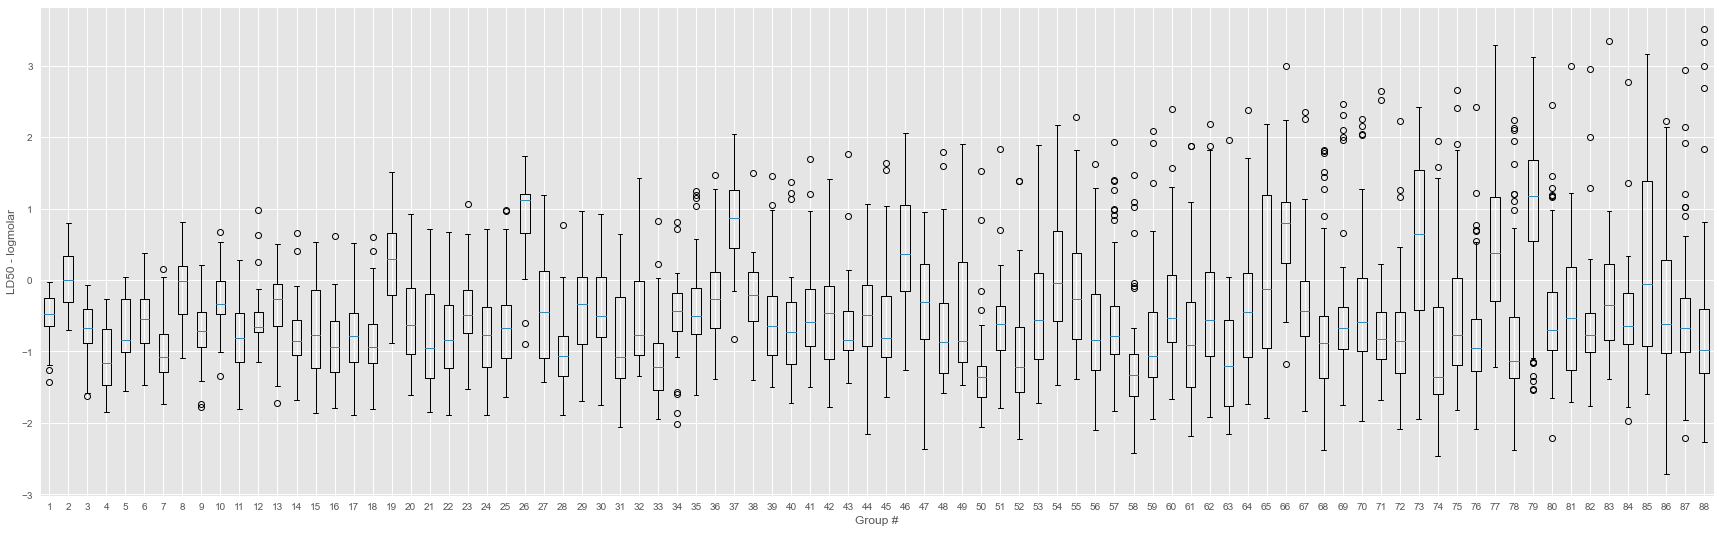

In [132]:
df_dist = plot_grps_dist(df3)
#plt.savefig(figures_dir+'Figure7.png')

In [135]:
df_dist.reset_index().to_csv(processed_dir+'Figure7_boxplot_data.csv')

In [143]:
df_dist.reset_index()['range'].median()

3.249787238405

## Visualize the errors
We want to find out if there are any classes which one fingerprint set signficantly outperforms the other

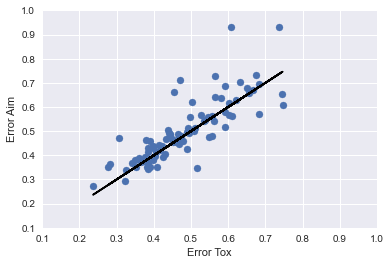

In [376]:
plt.style.use('seaborn')
X = df_grps['Error_tox']
Y = df_grps['Error_aim']
plt.figure(figsize=(6,4))
plt.plot(X,X,color='black')
plt.scatter(X,Y)
plt.ylim([0.1,1])
plt.xlim([0.1,1])
plt.ylabel('Error Aim')
plt.xlabel('Error Tox')
#plt.title('Classes and Errors')
plt.savefig(figures_dir+'Figure8.png', dpi = 300)

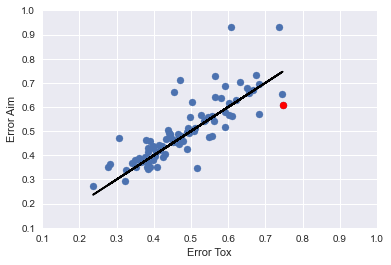

In [379]:
plt.style.use('seaborn')
X = df_grps['Error_tox']
Y = df_grps['Error_aim']
plt.figure(figsize=(6,4))
plt.plot(X,X,color='black')
plt.scatter(X,Y)
X2 = X['isoindoles and derivatives']
Y2 = Y['isoindoles and derivatives']
plt.scatter(X2,Y2,color='red')
plt.ylim([0.1,1])
plt.xlim([0.1,1])
plt.ylabel('Error Aim')
plt.xlabel('Error Tox')
plt.savefig(figures_dir+'Figure 9.png', dpi = 300)

We see a positive correlation of performance between the two feature sets. 

Some are "well-predicted" (<0.4) while other groups are poorly predicted (>0.6)

Not a significant difference in performance between the fingerprint sets for majority of groups

In [360]:
from collections import Counter
import numpy as np
def frag_freq(df,col_name):
    fragments = []
    for row in df[col_name]:  
        for fragment in row:
            fragments.append(fragment)

    frequency = Counter(fragments)

    for item, count in frequency.items():
        frequency[item] = np.round(frequency[item],3)
    
    df = pd.DataFrame.from_dict(frequency, orient='index', columns=[df.name])
    return df

In [361]:
df3

,dtxsid,class,subclass,Y_pred_aim,Diff_aim,aim_list,Y_true,Y_pred_tox,Diff_tox,tox_list
0,DTXSID5020281,benzene and substituted derivatives,nitrobenzenes,-0.329968,0.135371,"[Aromatic Carbon, CL [chlorine, aromatic atta...",-0.465339,-0.346871,0.118469,"[bond:CX_halide_aromatic-X_generic, bond:N(=O)..."
1,DTXSID8020961,benzene and substituted derivatives,nitrobenzenes,-0.842910,0.108124,"[Aromatic Carbon, N [aliphatic N, one aromati...",-0.734786,-0.838397,0.103611,"[bond:CN_amine_aromatic_generic, bond:CN_amine..."
2,DTXSID0021834,phenols,nitrophenols,-0.569759,0.482668,"[Aromatic Carbon, OH [hydroxy, aromatic attac...",-0.087091,-0.020099,0.066992,"[bond:COH_alcohol_aromatic, bond:COH_alcohol_a..."
3,DTXSID2044347,organooxygen compounds,carbonyl compounds,-1.143505,0.084580,"[ CH3 [aliphatic carbon], Aromatic Carbon, O ...",-1.058925,-1.077005,0.018080,"[bond:C=O_carbonyl_ab-unsaturated_generic, bon..."
4,DTXSID4025745,benzene and substituted derivatives,nitrobenzenes,-0.786114,0.236858,"[ CH2 [aliphatic carbon], CL [chlorine, aliph...",-1.022972,-0.927933,0.095039,"[bond:CX_halide_alkyl-X_aromatic_alkane, bond:..."
...,...,...,...,...,...,...,...,...,...,...
6923,DTXSID3044752,fatty acyls,fatty acid esters,-0.580946,0.396529,"[ CH2 [aliphatic carbon], =CH2 [olefinic carbo...",-0.184418,-1.149901,0.965483,"[bond:C(=O)O_carboxylicEster_acyclic, bond:C(=..."
6924,DTXSID80244288,organothiophosphorus compounds,NaN,0.015562,1.927141,"[ CH3 [aliphatic carbon], CH2 [aliphatic carb...",1.942702,0.940935,1.001768,"[bond:CS_sulfide, bond:PC_phosphorus_organo_ge..."
6925,DTXSID0022143,carboxylic acids and derivatives,acrylic acids and derivatives,-1.318011,1.034492,"[ CH3 [aliphatic carbon], CH2 [aliphatic carb...",-0.283519,-0.625075,0.341556,"[bond:C(=O)O_carboxylicEster_acyclic, bond:C(=..."
6926,DTXSID6020303,organonitrogen compounds,quaternary ammonium salts,-0.640617,0.061316,"[ CH3 [aliphatic carbon], CH2 [aliphatic carb...",-0.579302,-0.190255,0.389047,"[bond:CX_halide_alkyl-Cl_ethyl, bond:CX_halide..."


In [362]:
import functools

def freq_table(col_name):
    df_full = frag_freq(df3,col_name)

    dfs = [df_full]
    group_counts = [len(df3)]
    for i in grps:
        if i in chem_classes:
            df_label_i = df3[df3['class'] == i]
        else:
            df_label_i = df3[df3['subclass'] == i]
        if len(df_label_i) > 10:
            group_counts.append(len(df_label_i))
            df_label_i.name = i
            df_label = frag_freq(df_label_i,col_name)
            dfs.append(df_label)

    df = functools.reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='outer'),dfs)
    df.loc[len(df)] = group_counts
    df = df.rename(index = {(len(df)-1):"count"})
    df = df.fillna(0)
    return df

In [363]:
df_tox = freq_table('tox_list')
df_aim = freq_table('aim_list')

In [364]:
df_tox

,full,keto acids and derivatives,organic dithiophosphoric acids and derivatives,organic oxoanionic compounds,thiols,diazinanes,benzopyrans,alkyl halides,benzazepines,pyrrolines,...,nitrogen mustard compounds,guanidines,organic cyanides,cyclohexylamines,phenol ethers,anthracenes,thiocarbonyl compounds,furans,quinolines and derivatives,halohydrins
atom:element_metal_group_I_II,311,0.0,4.0,2.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0
atom:element_metal_metalloid,88,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
atom:element_metal_transistion_metal,22,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bond:C#N_cyano_acylcyanide,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bond:C#N_cyano_cyanamide,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ring:polycycle_bicyclo_[3.3.1]nonane,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ring:polycycle_bicyclo_[3.3.2]decane,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ring:polycycle_spiro_[4.5]decane,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ring:polycycle_tricyclo_adamantane,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Comparing the distribution of features between the full set and a subset based on structure

We choose the group "isoindoles and derivatives" 

With this, we can see how different the structures are (feature-wise) when compared to the full sets

In [394]:
import matplotlib.pyplot as plt

def plot_freq_comparison(df,grp,fp, filename):
    df2 = df.copy()
    df = df/df.iloc[-1]
    df = df.iloc[:-1]
    #df = df[df[grp]>0.05]
    X = df['full']
    Y = df[grp]
    fig, ax = plt.subplots()
    ax.plot(X,X,color='black')
    ax.scatter(X,Y,label=grp)
    #ax.set_title(f'Distribution of individual {fp} fragments',fontsize=22)
    ax.set_xlabel('fractional representation in full',fontsize=16)
    ax.set_ylabel('fractional representation in group',fontsize=16)
    ax.legend()
    fig.savefig(figures_dir+filename, dpi = 300)

    return df2[[grp,'full']].rename(columns={grp:'grp'})

The two figures above demonstrate the difference in fragment presence between the individual group and the full data set.

Above the black line = Larger fraction of structures contained this fragment in the group compared to full set

Below the line = Smaller fraction


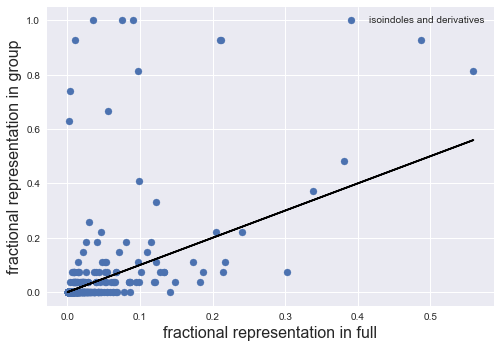

In [396]:
df_freq_tox = plot_freq_comparison(df_tox,'isoindoles and derivatives','tox', 'Figure10b.png')


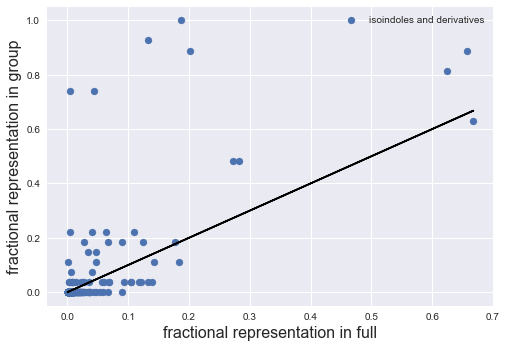

In [397]:
df_freq_aim = plot_freq_comparison(df_aim,'isoindoles and derivatives','aim', 'Figure10a.png')


In [398]:
classified = df_grps['N Struc'].sum()
N_unclassified = int(df.shape[0] - classified)

# Due to how the groups were chosen (we exclude those grps with less than 20),

print(f'There are {N_unclassified} unclassified chemicals')

There are 1462 unclassified chemicals


## Further Investigation:Looking at the individual error differences for the specific group of interest

- Are there any outliers?
- or Consistent trend?

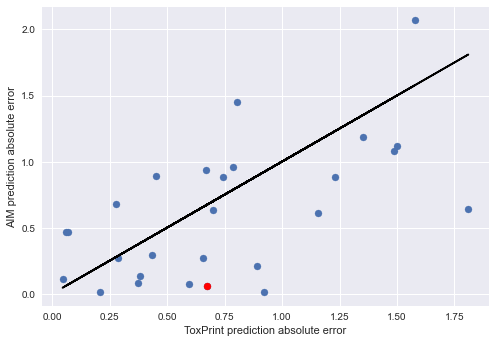

In [402]:
grp_name = 'isoindoles and derivatives'

grp_dataset = df3[df3['class']==grp_name]
if len(grp_dataset) == 0:
    grp_dataset = df3[df3['subclass']==grp_name]

X = grp_dataset['Diff_tox']
Y = grp_dataset['Diff_aim']
X2 = df3.iloc[1210]['Diff_tox']
Y2 = df3.iloc[1210]['Diff_aim']
plt.scatter(X,Y)
plt.scatter(X2,Y2,color='red')
plt.plot(X,X,color='black')
plt.xlabel('ToxPrint prediction absolute error')
plt.ylabel('AIM prediction absolute error')
plt.savefig(figures_dir+'Figure11.png', dpi = 300)


## Toxicity vs Similarity plot

Since our chemicals are predicted by nearest neighbors, we want to see why predictions are bad/good



In [370]:
# Getting a list of our groups
grps = df_grps.index.to_list()

df3['Diff_errs'] = df3['Diff_tox']-df3['Diff_aim']
df3[df3['class']=='isoindoles and derivatives'].sort_values(by=['Diff_errs']).head(1)

,dtxsid,class,subclass,Y_pred_aim,Diff_aim,aim_list,Y_true,Y_pred_tox,Diff_tox,tox_list,Diff_errs
3916,DTXSID9022524,isoindoles and derivatives,isoindolines,-1.091156,1.45009,"[ CH2 [aliphatic carbon], CH [aliphatic carbo...",0.358933,-0.446752,0.805685,"[bond:C(=O)N_carboxamide_(NHR), bond:C(=O)N_ca...",-0.644405


## Using Jaccard Similarity
$$
  J(A,B) = \frac{|A \cap B|}{|A \cup B|}
$$


We can calculate jaccard for a given structure by comparing the two lists of features

(N shared features by both) / (total features between both structures)

In [406]:
# Get jaccard just gives us the 
def get_jaccard(lst_0,lst_1):
    a = [item for item in lst_0 if item in lst_1]   # Features shared byBoth 
    b = [item for item in lst_0 if item not in lst_1] # Features in Struct 1 only
    c = [item for item in lst_1 if item not in lst_0] # Features in Struct 2 only

    jaccard = len(a)/(len(a)+len(b)+len(c))
    
    return jaccard

def all_jaccards(N,df,fp_set):
    lst_0 = df[f'{fp_set}_list'].iloc[[N]][N]

    data = []
    for i,row in df[[f'{fp_set}_list']].iterrows():
        lst_1 = df[f'{fp_set}_list'].iloc[[i]][i]
        jac = get_jaccard(lst_0,lst_1)
        if df.iloc[[N]]['class'][N] in grps:
            grp = df.iloc[[i]]['class'][i]
        else:
            grp = df.iloc[[i]]['subclass'][i]
        data.append([jac,grp])
    dfj = pd.DataFrame(data)
    dfj.name = N
    
    return dfj, N


def make_plot(N,df,fp_set, filename):
    df2, N = all_jaccards(N,df,fp_set)
    df_n = pd.merge(df,df2,how='outer',left_index=True,right_index=True)
    df_n = df_n.rename(columns={0:f'row {N} Similarity',1:'group'})
    
    X = df_n[f'row {N} Similarity'][1:]
    Y = df_n['Y_true'][1:]

    grp = df_n.iloc[[N]]['group'][N] 
    df_n_sub = df_n[df_n['group']==grp]

    X3 =  df_n[f'row {N} Similarity'][N:N+1]
    Y3 = df_n['Y_true'][N:N+1]

    plt.figure(figsize=(6,4))
    plt.scatter(X,Y,label='all')
    plt.scatter(X3,Y3,label='individual true',color='black')
    plt.axhline(y=df_n[f'Y_pred_{fp_set}'][N:N+1].iloc[0],color='red',label='prediction')
    plt.xlabel('Jaccard similarity')
    plt.ylabel('LD50  logmolar')
    plt.legend()
    plt.savefig(figures_dir+filename, dpi = 300)
    return df_n

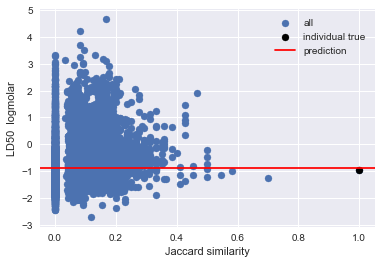

In [407]:
df_x = make_plot(1210,df3,'aim', 'Figure12a.png')
# Better prediction due to the nearest neighbors being close in toxicity

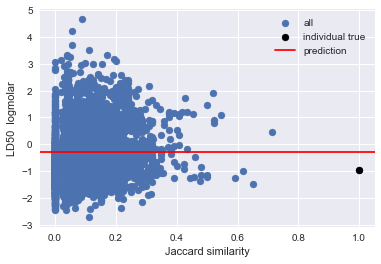

In [408]:
# Worse prediction due to the nearest neighbors being dissimilar in toxicity
df_x = make_plot(1210,df3,'tox', 'Figure12b.png')


### Process for selecting N (for above plot)

1. Select group of interest
2. Filter df3 by selecting chemicals only within group of interest
3. Select chemical in group of interest by some metric (error), the index number of that chemical is N

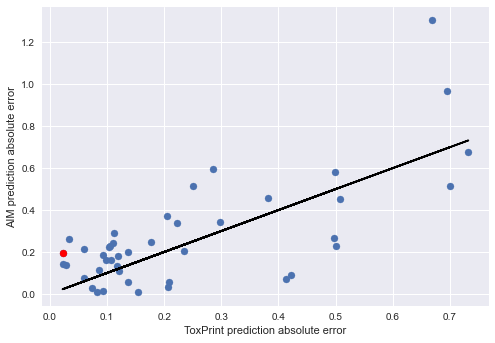

In [410]:
grp_name = 'phenoxyacetic acid derivatives'

grp_dataset = df3[df3['class']==grp_name]
if len(grp_dataset) == 0:
    grp_dataset = df3[df3['subclass']==grp_name]

X = grp_dataset['Diff_tox']
Y = grp_dataset['Diff_aim']
X2 = df3.iloc[3359]['Diff_tox']
Y2 = df3.iloc[3359]['Diff_aim']
plt.scatter(X,Y)
plt.scatter(X2,Y2,color='red')
plt.plot(X,X,color='black')
plt.xlabel('ToxPrint prediction absolute error')
plt.ylabel('AIM prediction absolute error')
plt.savefig(figures_dir+'FigureS1.png', dpi = 300)

Text(0.5, 1.0, 'Classes and Errors')

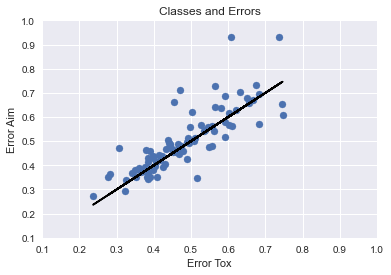

In [37]:
plt.style.use('seaborn')
X = df_grps['Error_tox']
Y = df_grps['Error_aim']
plt.figure(figsize=(6,4))
plt.plot(X,X,color='black')
plt.scatter(X,Y)
plt.ylim([0.1,1])
plt.xlim([0.1,1])
plt.ylabel('Error Aim')
plt.xlabel('Error Tox')
plt.title('Classes and Errors')

In [38]:
#1
group = df_grps.sort_values(by=['Error_tox']).index[0] #Group which has lowest abs error

#2
grp_dataset = df3[df3['class']==group]
if len(grp_dataset) == 0:
    grp_dataset = df3[df3['subclass']==group]
#3
num = grp_dataset.sort_values(by=['Diff_tox']).index[0] # smallest error in group

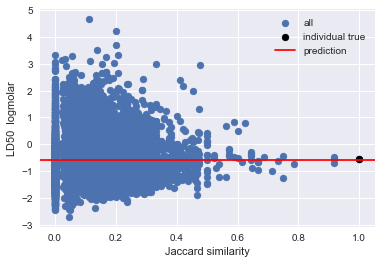

In [413]:
df_x = make_plot(3359,df3,'tox', 'Figure13b.png')


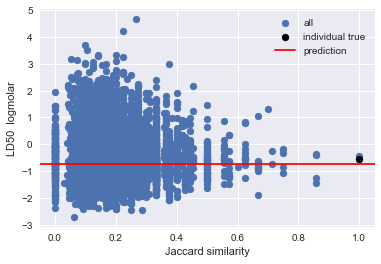

In [415]:
df_x = make_plot(3359,df3,'aim', 'Figure13a.png')


In [41]:
#1
group = df_grps.sort_values(by=['Error_tox'],ascending=False).index[0] #Group which has LARGEST abs error

#2
grp_dataset = df3[df3['class']==group]
if len(grp_dataset) == 0:
    grp_dataset = df3[df3['subclass']==group]
#3
num = grp_dataset.sort_values(by=['Diff_tox'],ascending=False).index[0] # LARGEST error in group

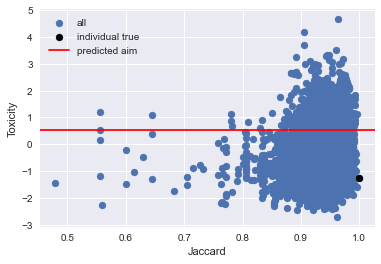

In [42]:
df_x = make_plot(num,df3,'tox')


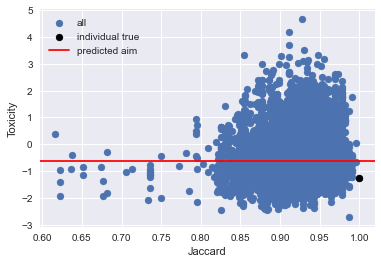

In [43]:
df_x = make_plot(num,df3,'aim')


In [387]:
df3[df3['dtxsid'] == 'DTXSID0021385']

,dtxsid,class,subclass,Y_pred_aim,Diff_aim,aim_list,Y_true,Y_pred_tox,Diff_tox,tox_list,Diff_errs
1210,DTXSID0021385,isoindoles and derivatives,isoindolines,-0.892162,0.056686,"[C [aliphatic carbon No H, not tert], N [alip...",-0.948847,-0.273474,0.675374,"[bond:C(=O)N_carboxamide_generic, bond:C=O_car...",0.618688


In [389]:
df3[df3['dtxsid'] == 'DTXSID2034700']

,dtxsid,class,subclass,Y_pred_aim,Diff_aim,aim_list,Y_true,Y_pred_tox,Diff_tox,tox_list,Diff_errs
3359,DTXSID2034700,benzene and substituted derivatives,phenoxyacetic acid derivatives,-0.748312,0.192747,"[ CH3 [aliphatic carbon], CH2 [aliphatic carb...",-0.555565,-0.577682,0.022117,"[atom:element_metal_group_I_II, bond:C(=O)O_ca...",-0.17063
